<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
#import seaborn as sns
#plt.style.use('fivethirtyeight') #'seaborn-notebook'
#plt.rcParams.update({'font.size': 14})il
import matplotlib.ticker as mticker



In [2]:
def read_data(url, dataset_name, sep=","):
    r = requests.get(url)
    soup = BeautifulSoup.BeautifulSoup(r.text)
    ressources_list = soup.find("div", "resources-list")
    url = None
    for article in ressources_list.find_all("article"):
      if dataset_name in article.div.h4.text:
        url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
        break
    if url == None:
      raise("data not found")
    return pd.read_csv(url, sep=sep)

dept_data = pd.read_csv(
    "https://public.opendatasoft.com/explore/dataset/population-francaise-par-departement-2018/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B",
    sep=";",
    header=0,
    names=["code", "nom", "population"],
    index_col=0,
    usecols=[0,1,2]
    )

In [3]:
# lecture des données

hospi_dept = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-nouveaux-covid19",
    ";"
)
print("dernier jour hospitalisations par département :", max(hospi_dept.jour))

hospi_age = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-classe-age-covid19",
    ";"
)
print("dernier jour hospitalisations par age :", max(hospi_age.jour))

test_age = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19/",
    "sp-pos-quot-fra",
    ";"
)
print("dernier jour tests par age :", max(test_age.jour))

dernier jour hospitalisations par département : 2020-10-30
dernier jour hospitalisations par age : 2020-10-30
dernier jour tests par age : 2020-10-27


In [22]:
def display_df(df, legend=None, title="", logscale=False):
  if not legend:
    legend=df.columns
  fig = plt.figure(figsize=(20,8))
  ax = plt.axes()
  if logscale:
      ax.yscale('log')
  ax.plot(df, marker="o")
  plt.xticks(rotation=75)
  plt.title(title, fontsize=22)
  plt.legend(legend, loc=2, fontsize=14)
  tick_freq = df.shape[0] // 60
  myLocator = mticker.MultipleLocator(tick_freq)
  ax.xaxis.set_major_locator(myLocator)
  plt.show()

def window(df, min_date="2020-01-01", max_date="2022-01-01"):
  if "jour" in df.columns:
    return df[(df.jour >= min_date) & (df.jour <= max_date)]
  return df[(df.index>= min_date) & (df.index <= max_date)]

def prepare_hospi_dept(dept=None):
  if dept:
    daily = hospi_dept[hospi_dept.dep == dept].set_index("jour")[["incid_hosp", "incid_rea"]]
  else:
    daily = hospi_dept.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum()

  lissage_hebdo = daily.rolling(7, center=True).mean()
  lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

  return pd.concat([daily, lissage_hebdo], axis=1)

def variation_hospi_dept(dept=None):
  df = prepare_hospi_dept(dept)
  return df[["hosp_lisse", "rea_lisse"]].pct_change().rolling(7, center=True).mean()

def prepare_hospi_age(ages=None):
  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values="hosp", aggfunc=sum)

def prepare_rea_age(ages=None):
  if ages:
    df = hospi_age[hospi_age.cl_age90.isin(ages)]
  else:
    df = hospi_age[hospi_age.cl_age90 > 0]
  return df.pivot_table(index="jour", columns="cl_age90", values="rea", aggfunc=sum)

def variation_hospi_age(ages=None):
  df = prepare_hospi_age(ages)
  return df.rolling(7, center=True).mean().pct_change().rolling(7, center=True).mean()


In [185]:
def dept_name(dept=None):
  if dept:
    return dept_data.loc[dept,"nom"]
  else:
    return "France"

def display_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
    window(prepare_hospi_dept(dept), min_date, max_date),
    legend=["hospitalisations", "réanimation", "hospitalisation 7j", "réanimation 7j"],
    title=dept_name(dept)
  )

def display_variation_hospi_dept(dept=None, min_date="2020-01-01", max_date="2022-01-01"):
  display_df(
      window(variation_hospi_dept(dept), min_date, max_date),
      legend=["hospitalisations", "réanimations"],
      title=dept_name(dept)
  ) 

def print_latest_hospi(dept=None):
  if dept:
    population = dept_data.loc[dept,"population"]
  else:
    population = dept_data.loc[:, "population"].sum()
  df = prepare_hospi_dept(dept)
  hospi_lisse = df["hosp_lisse"].dropna()[-10:]
  rea_lisse = df["rea_lisse"].dropna()[-10:]
  disp = ["incid_hosp", "incid_rea", "hosp_lisse", "rea_lisse"]
  print("\ndernières données : \n")
  print(df[disp].apply(np.rint).tail(4).head(1))
  print()
  print(f"hospitalisations pour 100k habitants {max(hospi_lisse)/ population * 100000:.2f}")
  print(f"réanimations pour 100k habitants     {max(rea_lisse)/ population * 100000:.2f}")



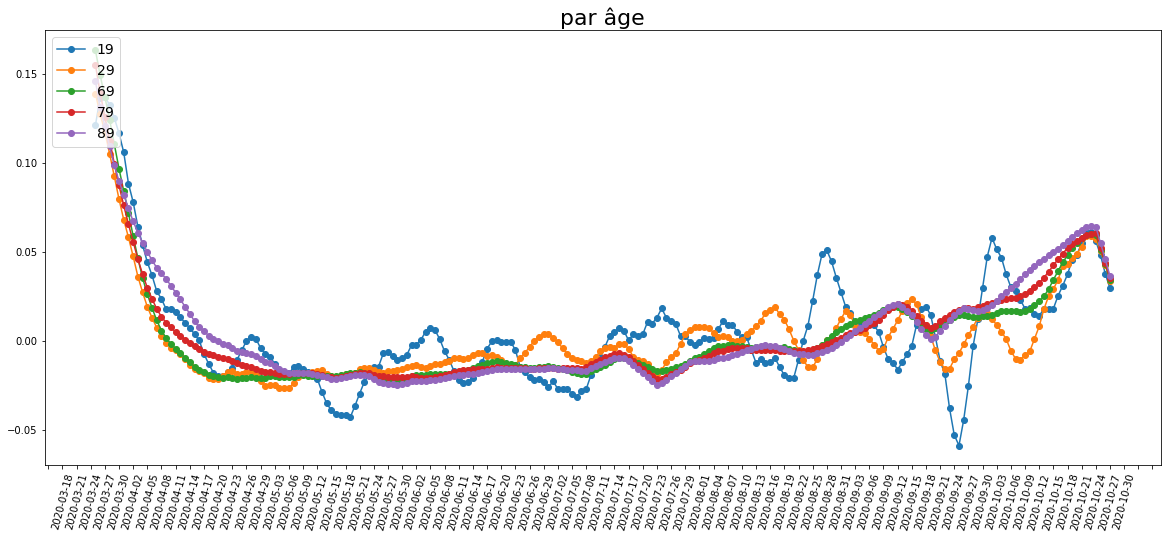

In [23]:
# display_variation_hospi_dept("75")
#display_df(window(prepare_hospi_age([0]), min_date="2020-08-01"), title="par âge")
#display_df(window(prepare_rea_age()),title="par âge")
display_df(variation_hospi_age([19, 29, 69, 79, 89]), title="par âge")

In [151]:
def display_df(df, title, logscale=False, population=None):
    """
    df a pour index les jours et les cols ["incid_hosp", "incid_rea"]
    """
    daily = df[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    dept = pd.concat([daily, lissage_hebdo], axis=1)
    cols = ["incid_hosp",  "hosp_lisse",  "incid_rea", "rea_lisse"]
    legend = ["hospitalisations", "hospitalisation 7j", "réanimation", "réanimation 7j"]
    disp = ["incid_hosp", "incid_rea", "hosp_lisse", "rea_lisse"]

    plt.figure(figsize=(20,8))
    if logscale:
        plt.yscale('log')
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(title, fontsize=22)
    plt.legend(legend, loc=2, fontsize=14)
    plt.show()
    print("\ndernières données : \n")
    print(dept[disp].apply(np.rint).tail(30).head(1))
    print(dept[disp].apply(np.rint).tail(4))
    if population:
      hospi_lisse = dept["hosp_lisse"].dropna()[-10:]
      rea_lisse = dept["rea_lisse"].dropna()[-10:]
      print()
      print(f"hospitalisations pour 100k habitants {max(hospi_lisse)/ population * 100:.2f}")
      print(f"réanimations pour 100k habitants     {max(rea_lisse)/ population * 100:.2f}")


In [79]:
def display_df2(df, title):
    """
    df a pour index les jours et les cols ["incid_hosp", "incid_rea"]
    """
    daily = df[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    vari = lissage_hebdo.pct_change().rolling(7, center=True).mean()

    dept = pd.concat([daily, lissage_hebdo], axis=1)
    cols = ["hosp_lisse",  "rea_lisse"]
    legend = ["hospitalisations", "reanimations"]

    fig = plt.figure(figsize=(20,8))
    ax = plt.axes()
    ax.plot(vari[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(title, fontsize=22)
    plt.legend(legend, loc=2, fontsize=14)
    #ax.xaxis_date()
    #fig.autofmt_xdate()
    myLocator = mticker.MultipleLocator(tick_freq)
    ax.xaxis.set_major_locator(myLocator)
    plt.show()


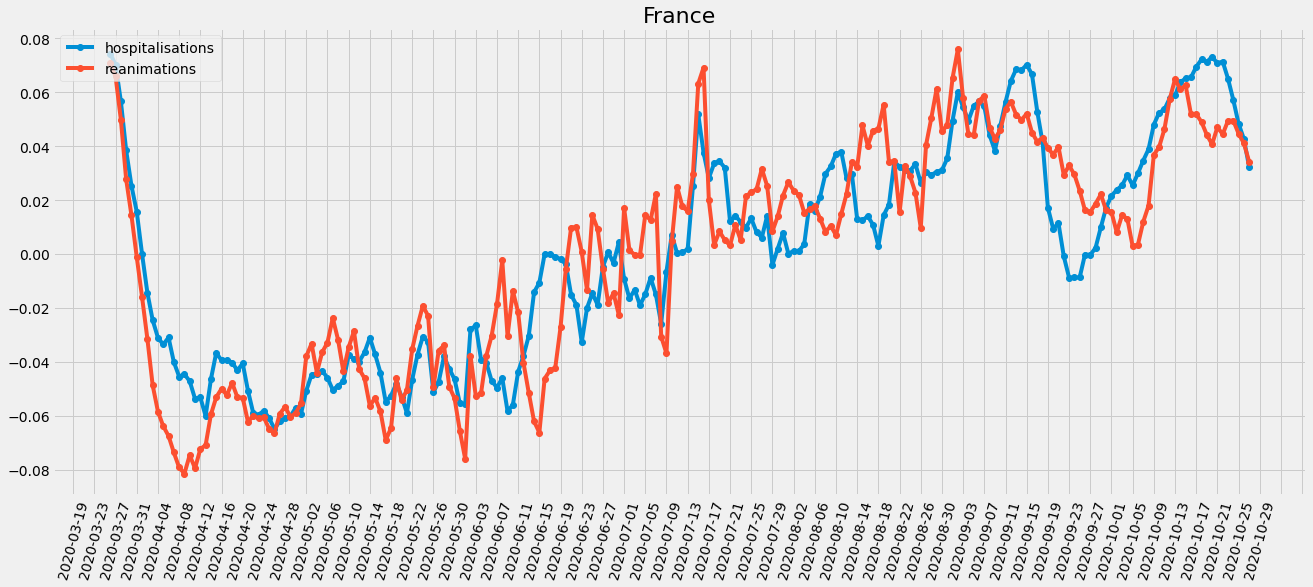

In [82]:
display_df2(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France")


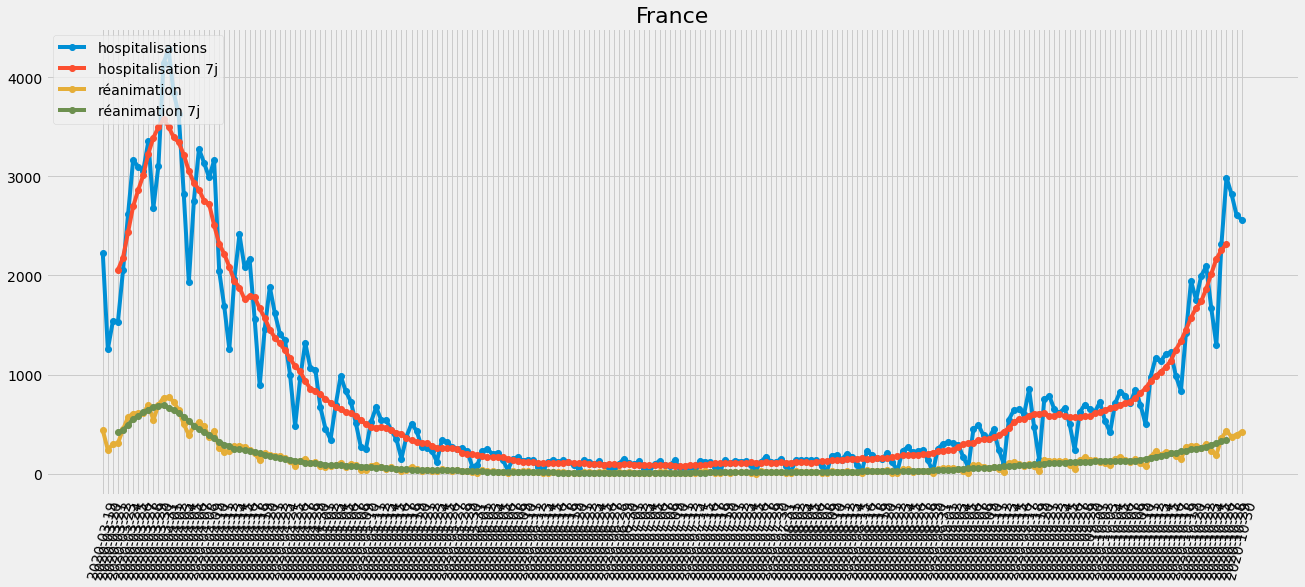


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-10-01       626.0      142.0       609.0      128.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-10-27      2988.0      431.0      2323.0      343.0
2020-10-28      2821.0      372.0         NaN        NaN
2020-10-29      2607.0      395.0         NaN        NaN
2020-10-30      2563.0      422.0         NaN        NaN

hospitalisations pour 100k habitants 5.34
réanimations pour 100k habitants     1.03


In [148]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France", population=66990)


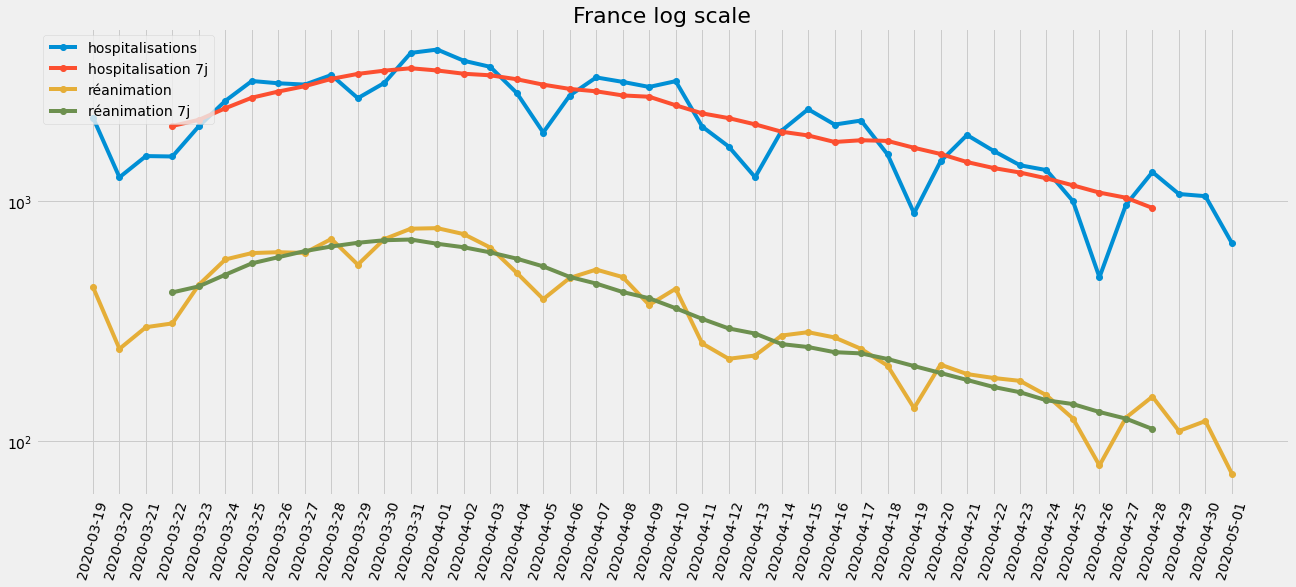


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02      3845.0      728.0      3394.0      642.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28      1321.0      153.0       936.0      112.0
2020-04-29      1070.0      110.0         NaN        NaN
2020-04-30      1048.0      121.0         NaN        NaN
2020-05-01       668.0       73.0         NaN        NaN


In [30]:
display_df(df.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "France log scale", logscale=True)

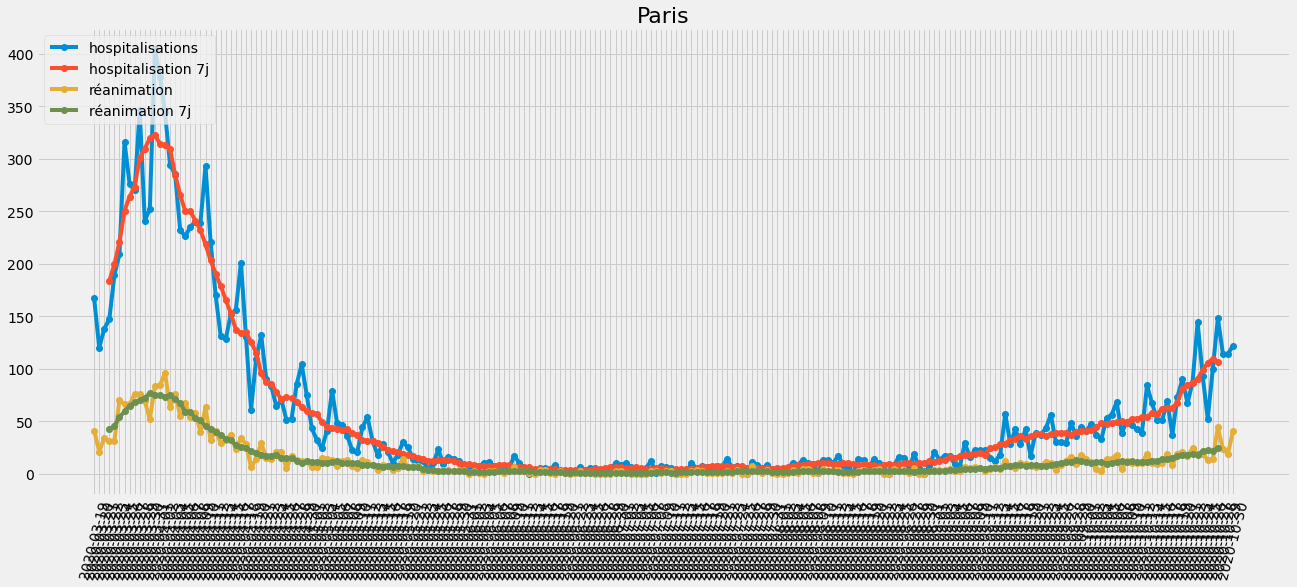


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-10-01        41.0       14.0        41.0       11.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-10-27       148.0       44.0       106.0       25.0
2020-10-28       114.0       23.0         NaN        NaN
2020-10-29       114.0       19.0         NaN        NaN
2020-10-30       122.0       41.0         NaN        NaN

hospitalisations pour 100k habitants 5.09
réanimations pour 100k habitants     1.15


In [152]:
display_df(df[df.dep=="75"].set_index("jour", drop=True), "Paris", population = 2148)

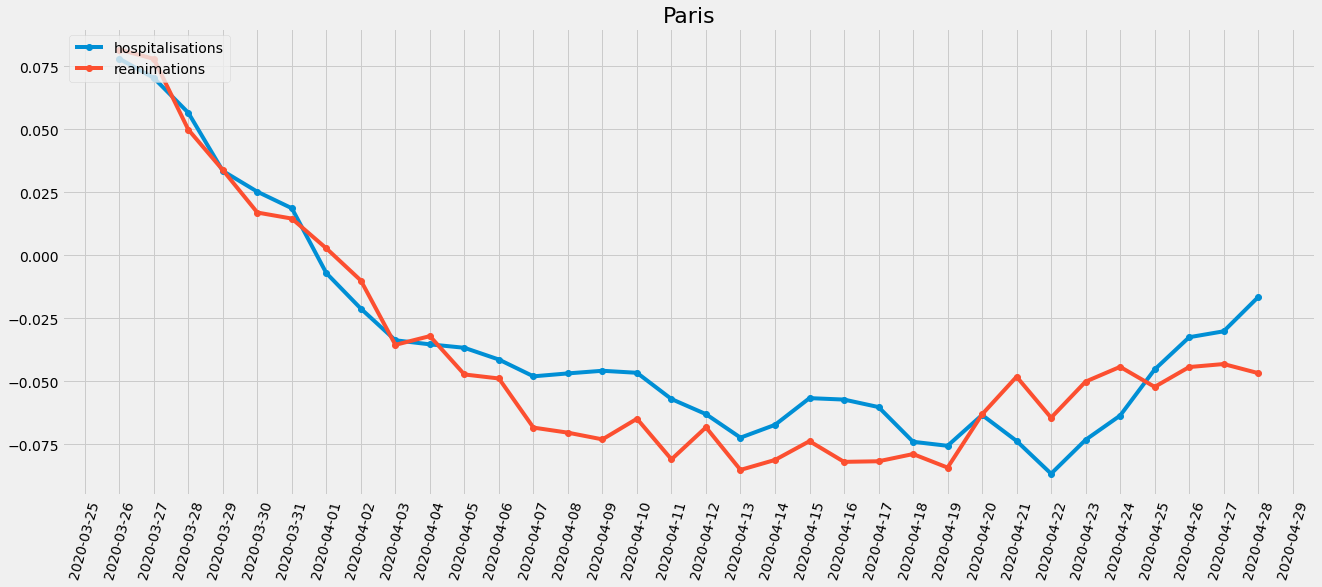

In [32]:
display_df2(df[df.dep=="75"].set_index("jour", drop=True), "Paris")

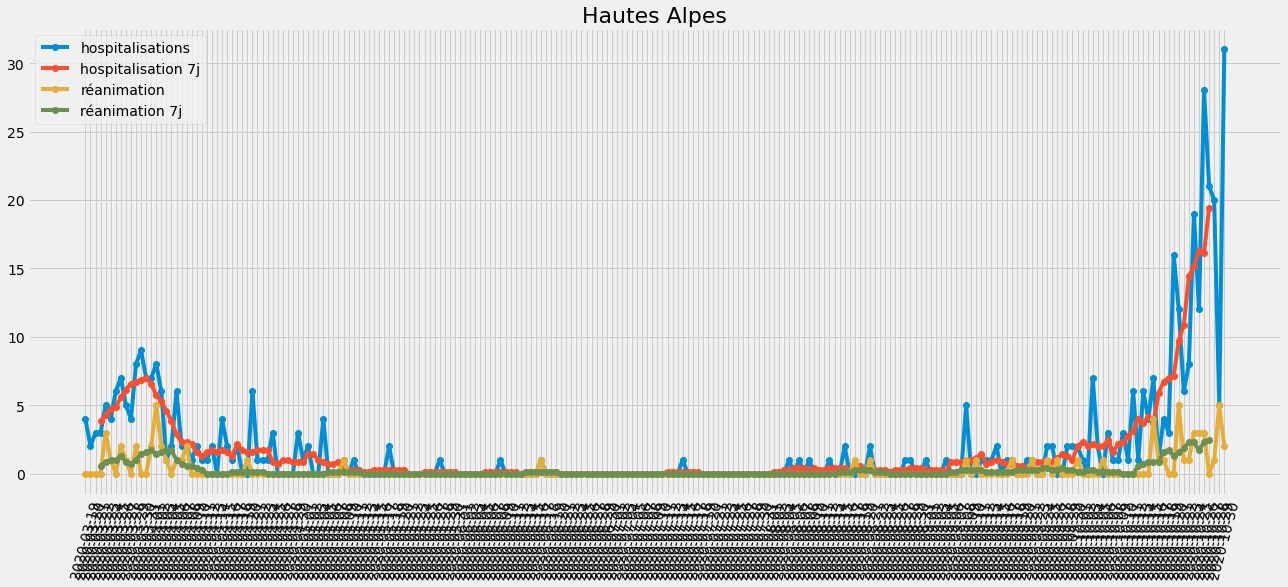


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-10-01         2.0        1.0         2.0        0.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-10-27        21.0        0.0        19.0        2.0
2020-10-28        20.0        1.0         NaN        NaN
2020-10-29         5.0        5.0         NaN        NaN
2020-10-30        31.0        2.0         NaN        NaN

hospitalisations pour 100k habitants 13.68
réanimations pour 100k habitants     1.71


In [153]:
display_df(df[df.dep=="05"].set_index("jour", drop=True),"Hautes Alpes", population=142)

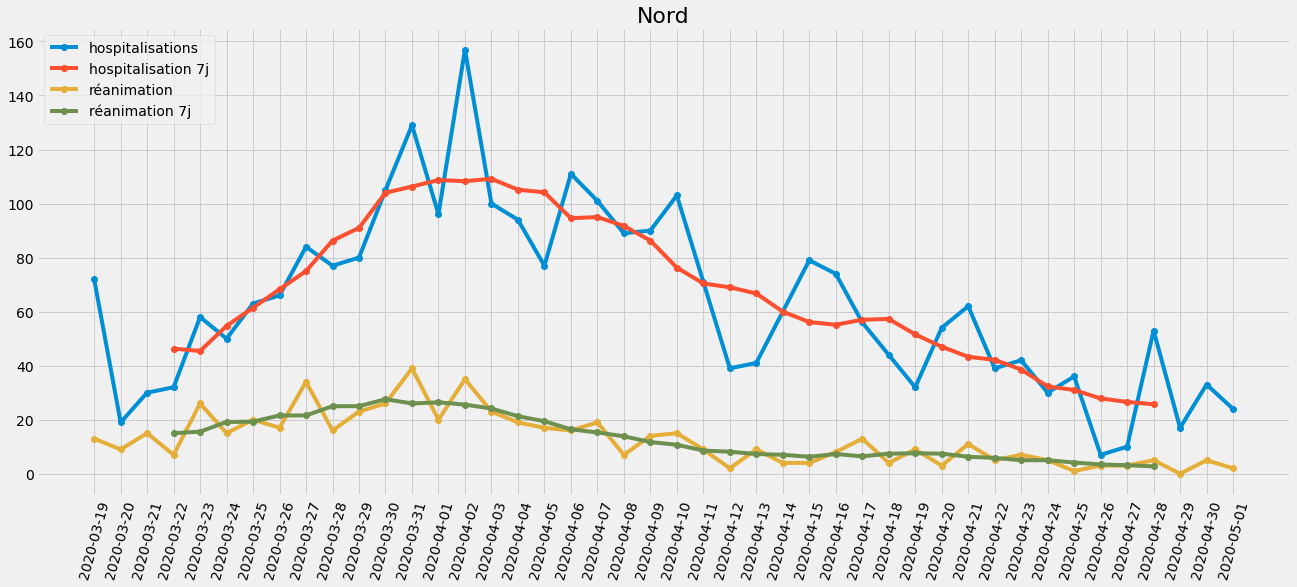


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02       157.0       35.0       108.0       26.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28        53.0        5.0        26.0        3.0
2020-04-29        17.0        0.0         NaN        NaN
2020-04-30        33.0        5.0         NaN        NaN
2020-05-01        24.0        2.0         NaN        NaN

hospitalisations pour 100k habitants 4.11
réanimations pour 100k habitants     0.99


In [34]:
display_df(df[df.dep=="59"].set_index("jour", drop=True),"Nord", population=2592)

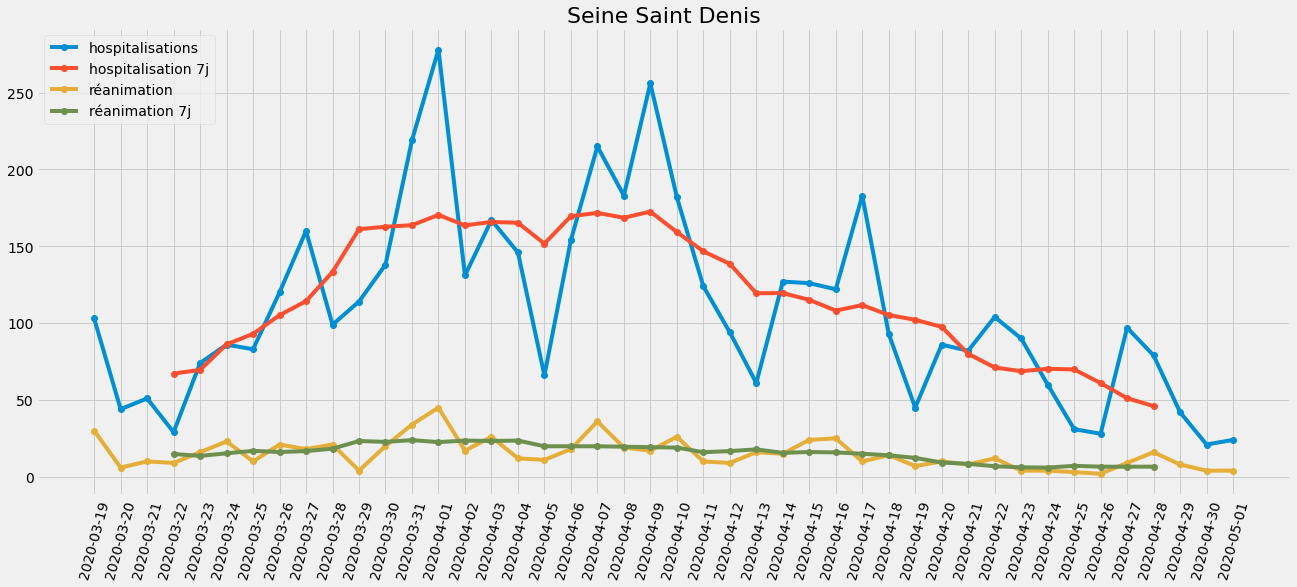


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02       131.0       17.0       164.0       24.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28        79.0       16.0        46.0        7.0
2020-04-29        42.0        8.0         NaN        NaN
2020-04-30        21.0        4.0         NaN        NaN
2020-05-01        24.0        4.0         NaN        NaN

hospitalisations pour 100k habitants 10.06
réanimations pour 100k habitants     1.41


In [35]:
display_df(df[df.dep=="93"].set_index("jour", drop=True),"Seine Saint Denis", population=1654)

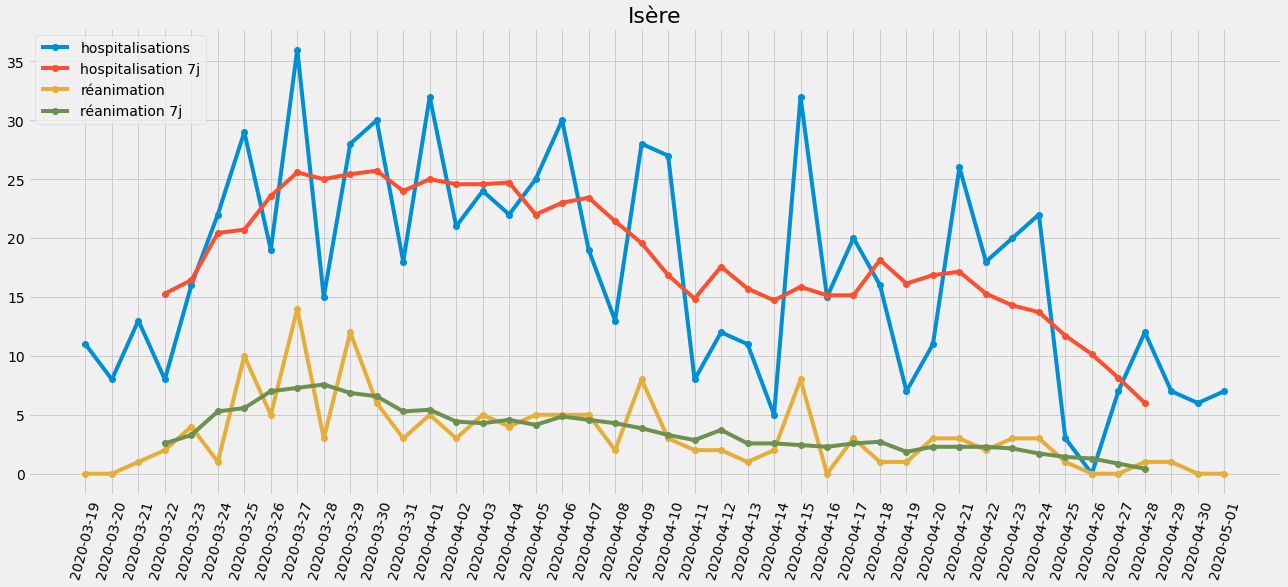


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02        21.0        3.0        25.0        4.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28        12.0        1.0         6.0        0.0
2020-04-29         7.0        1.0         NaN        NaN
2020-04-30         6.0        0.0         NaN        NaN
2020-05-01         7.0        0.0         NaN        NaN

hospitalisations pour 100k habitants 1.98
réanimations pour 100k habitants     0.52


In [36]:
display_df(df[df.dep=="38"].set_index("jour", drop=True),"Isère", population=1262)

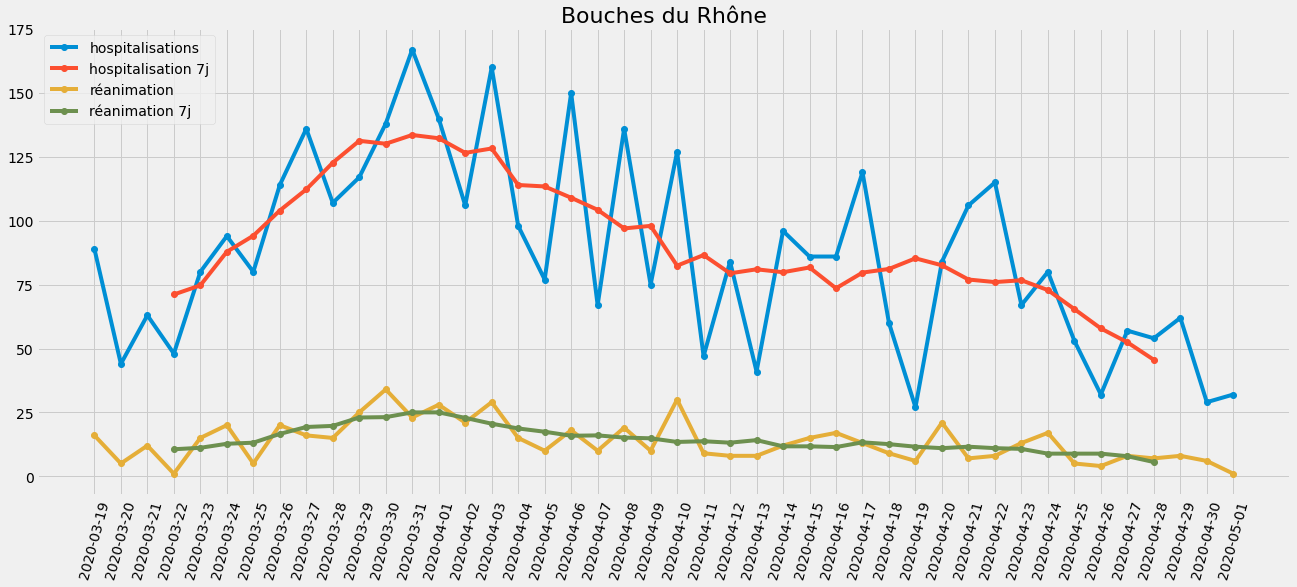


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02       106.0       21.0       127.0       23.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28        54.0        7.0        46.0        6.0
2020-04-29        62.0        8.0         NaN        NaN
2020-04-30        29.0        6.0         NaN        NaN
2020-05-01        32.0        1.0         NaN        NaN

hospitalisations pour 100k habitants 6.35
réanimations pour 100k habitants     1.12


In [37]:
display_df(df[df.dep=="13"].set_index("jour", drop=True),"Bouches du Rhône", population=2035)

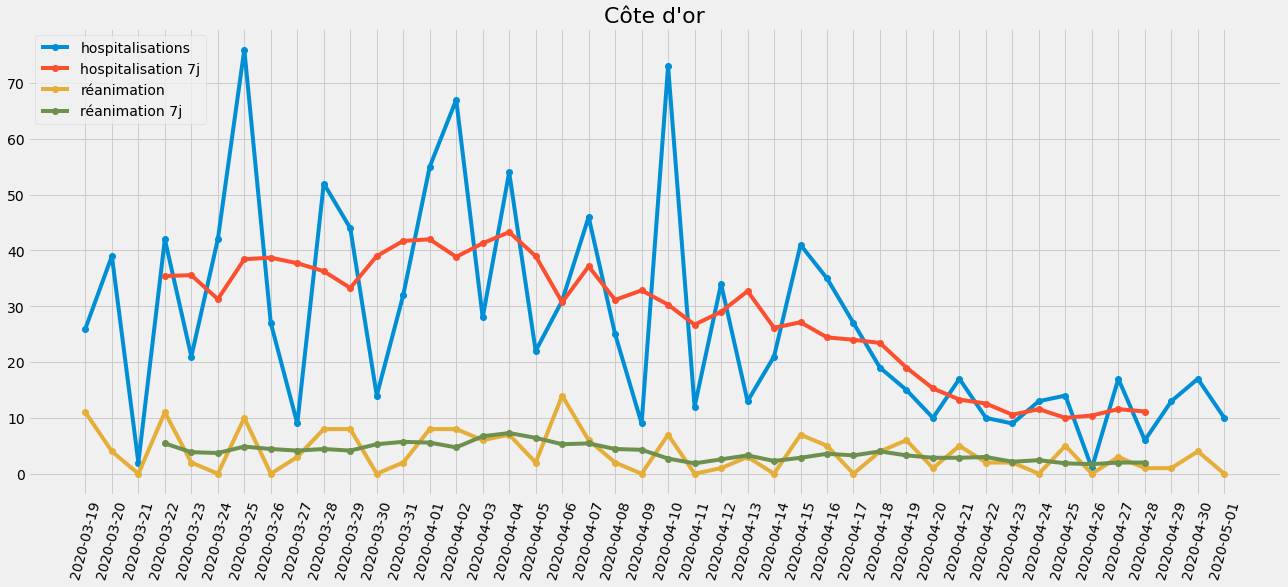


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02        67.0        8.0        39.0        5.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28         6.0        1.0        11.0        2.0
2020-04-29        13.0        1.0         NaN        NaN
2020-04-30        17.0        4.0         NaN        NaN
2020-05-01        10.0        0.0         NaN        NaN

hospitalisations pour 100k habitants 7.64
réanimations pour 100k habitants     1.12


In [38]:
display_df(df[df.dep=="21"].set_index("jour", drop=True),"Côte d'or", population=533)

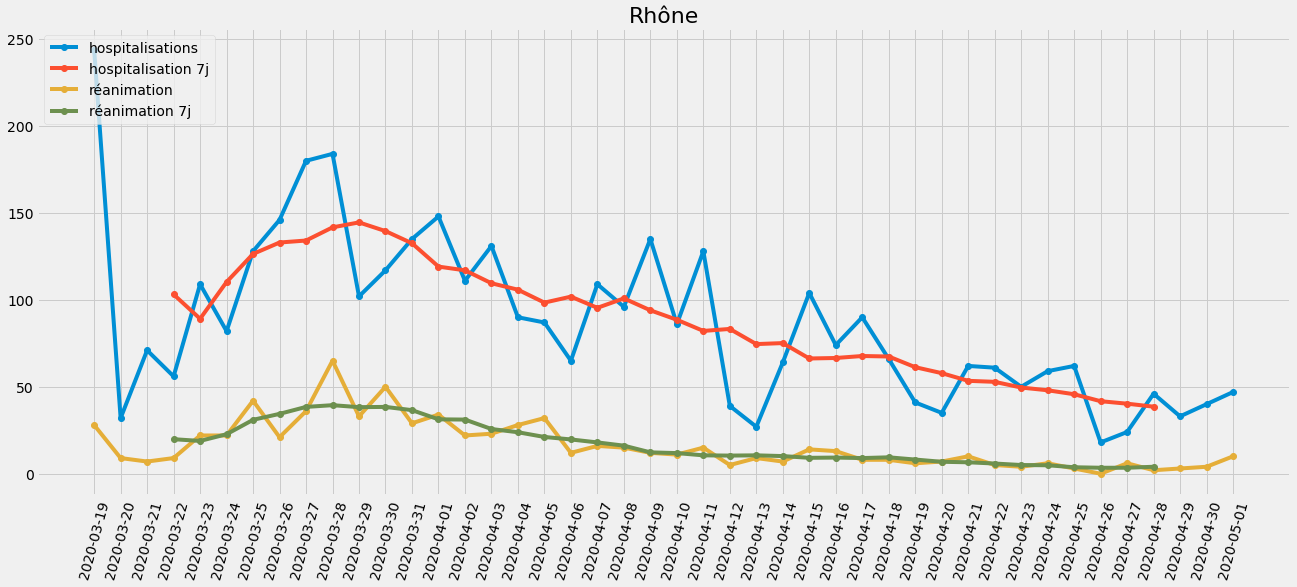


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02       111.0       22.0       117.0       31.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28        46.0        2.0        39.0        4.0
2020-04-29        33.0        3.0         NaN        NaN
2020-04-30        40.0        4.0         NaN        NaN
2020-05-01        47.0       10.0         NaN        NaN

hospitalisations pour 100k habitants 7.23
réanimations pour 100k habitants     1.95


In [39]:
display_df(df[df.dep=="69"].set_index("jour", drop=True),"Rhône", population=1882)

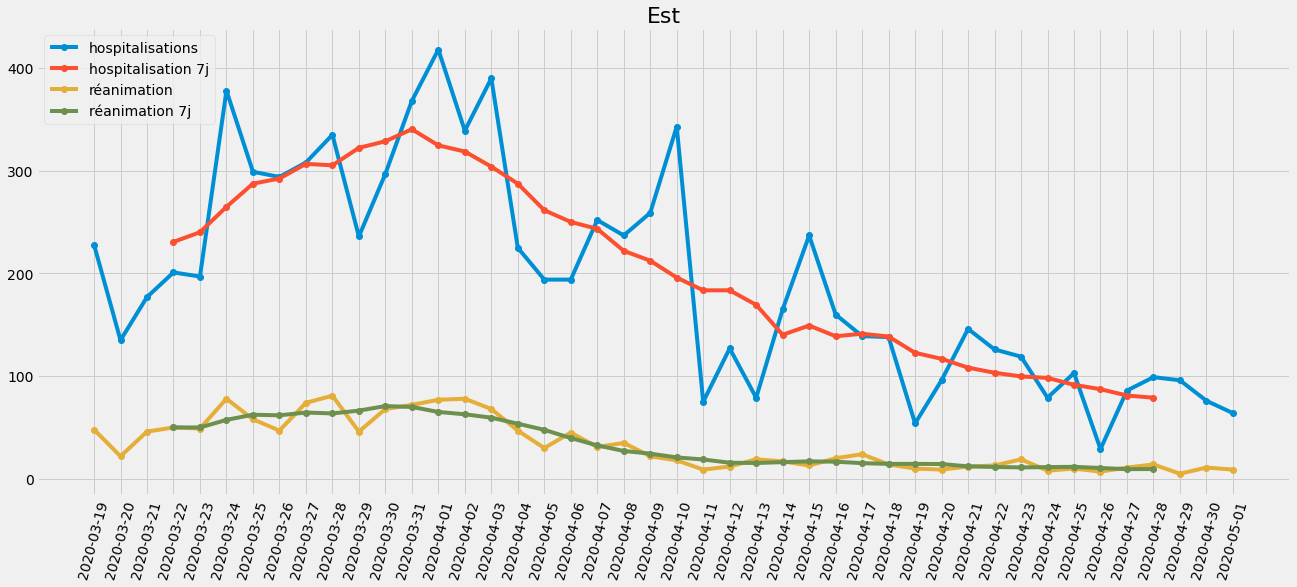


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02       339.0       78.0       319.0       63.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28        99.0       14.0        79.0       10.0
2020-04-29        96.0        5.0         NaN        NaN
2020-04-30        76.0       11.0         NaN        NaN
2020-05-01        64.0        9.0         NaN        NaN

hospitalisations pour 100k habitants 9.77
réanimations pour 100k habitants     2.02


In [40]:
df1 = df[(df.dep=="67") | (df.dep == "88")| (df.dep == "54") | (df.dep == "57")]

display_df(df1.groupby(["jour"])[["incid_hosp", "incid_rea"]].sum(), "Est", population=761+1127+361+1036)

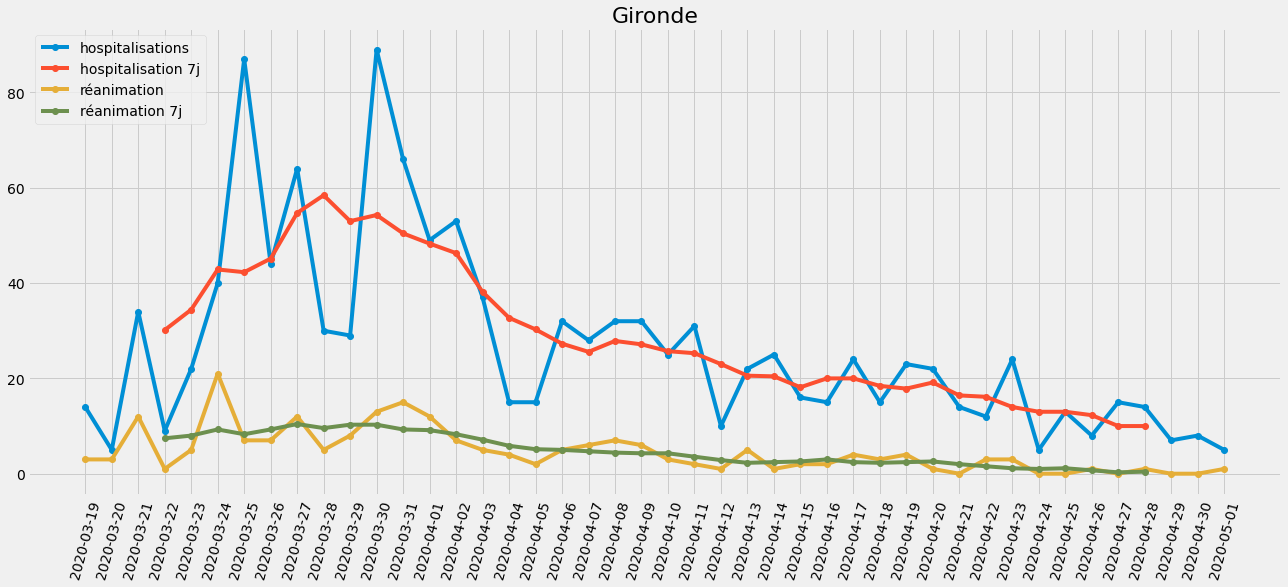


dernières données : 

            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-02        53.0        7.0        46.0        8.0
            incid_hosp  incid_rea  hosp_lisse  rea_lisse
jour                                                    
2020-04-28        14.0        1.0        10.0        0.0
2020-04-29         7.0        0.0         NaN        NaN
2020-04-30         8.0        0.0         NaN        NaN
2020-05-01         5.0        1.0         NaN        NaN

hospitalisations pour 100k habitants 3.22
réanimations pour 100k habitants     0.60


In [41]:
display_df(df[df.dep=="33"].set_index("jour", drop=True),"Gironde", False, population=1620)

In [42]:
cumul = read_data(
    "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/",
    "donnees-hospitalieres-covid19",
    ";"
)

c = cumul.groupby(["dep", "jour"])["hosp", "rea"].sum().reset_index()
c.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys


,dep,jour,hosp,rea
22922,976,2020-10-26,28,8
22923,976,2020-10-27,26,8
22924,976,2020-10-28,26,10
22925,976,2020-10-29,26,10
22926,976,2020-10-30,28,12


In [43]:
def display_dept(d_number, d_name, population=None):
    dept = df[df.dep==d_number]
    dept.set_index(dept.jour, inplace=True)

    daily = dept[["incid_hosp", "incid_rea"]]
    lissage_hebdo = daily.rolling(7, center=True).mean()
    lissage_hebdo.columns = ["hosp_lisse", "rea_lisse"]

    # désaisonalisation
    if False: #dept["incid_hosp"].min() > 5:
        modele_hebdo = daily.iloc[-7:,:].to_numpy() + daily.iloc[-14:-7,:].to_numpy() + daily.iloc[-21:-14,:].to_numpy()
        modele_hebdo = modele_hebdo + np.array([np.arange(-3,4), np.zeros(7)]).T * (daily.iloc[-21:-14, 0].mean()- daily.iloc[-7:,0].mean()) / 14 
        modele_hebdo =  modele_hebdo / modele_hebdo.mean(axis=0)
        desaiso = pd.concat([daily.iloc[-7*i -7 : -7*i ]/modele_hebdo for i in range(4,0,-1)] + [daily.iloc[-7:,:]/modele_hebdo]).rolling(3, center=True).mean()
        desaiso.columns = ["hosp_desaiso", "rea_desaiso"]
        dept = pd.concat([daily, lissage_hebdo, desaiso], axis=1)
        cols = ["incid_hosp",  "hosp_lisse", "hosp_desaiso", "incid_rea"]
        legend = ["hospitalisations", "hospitalisation lissées 7j", "hospitalisations déshebdomadérisées", "réanimation"]
    else:
        dept = pd.concat([daily, lissage_hebdo], axis=1)
        cols = ["incid_hosp",  "hosp_lisse",  "incid_rea", "rea_lisse"]
        legend = ["hospitalisations", "hospitalisation 7j", "réanimation", "réanimation 7j"]

    plt.figure(figsize=(15,8))
    plt.plot(dept[cols], marker="o")
    plt.xticks(rotation=75)
    plt.title(d_name, fontsize=22)
    plt.legend(legend, loc=1, fontsize=14)
    plt.show()
    print("\ndernières données lissées 7j: \n")
    print(dept.rolling(7).mean().apply(np.rint).tail())
    